In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#### Задание: На примере датасета персонажей мультфильма Симпсонов:

1. Модифицируйте код обучения, используя различные типы LR Schedulers из Pytorch. Проведите минимум 2 эксперимента с разными шедулерами.
1. Подберите аугментации train данных, при которых итоговое качество на валидации станет сильно хуже, чем полученное на занятии.
1. Возьмите любую архитектуру (VGG, EfficientNet или MobileNet) и примените к ней методы, которые разбирались на занятии.
1. Оформите вывод по результатам проведённых экспериментов.

In [2]:
import os
import time
import glob

from tqdm.notebook import tqdm
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F
#from torchsummary import summary

import torchvision
from torchvision import transforms

from IPython.display import clear_output
%matplotlib inline

sns.set(font_scale=1.2)
# # sns.set_style(style='whitegrid')
# device_num = 0
# torch.cuda.set_device(device_num)

In [3]:
# разделим картинки на train и val в отношении 70 на 30 для каждого класса
data_dir = "/kaggle/input/the-simpsons-characters-dataset/simpsons_dataset/simpsons_dataset"
data_image_paths = glob.glob(f"{data_dir}/*/*.jpg")
data_image_labels = [path.split('/')[-2] for path in data_image_paths]
train_files_path, val_files_path = train_test_split(
    data_image_paths, 
    test_size=0.3,
    stratify=data_image_labels
)

print(
    f"Изображений в train: {len(train_files_path)}\nИзображений в val: {len(val_files_path)}"
)

Изображений в train: 14653
Изображений в val: 6280


In [17]:
data_image_labels

['rainier_wolfcastle',
 'rainier_wolfcastle',
 'rainier_wolfcastle',
 'rainier_wolfcastle',
 'rainier_wolfcastle',
 'rainier_wolfcastle',
 'rainier_wolfcastle',
 'rainier_wolfcastle',
 'rainier_wolfcastle',
 'rainier_wolfcastle',
 'rainier_wolfcastle',
 'rainier_wolfcastle',
 'rainier_wolfcastle',
 'rainier_wolfcastle',
 'rainier_wolfcastle',
 'rainier_wolfcastle',
 'rainier_wolfcastle',
 'rainier_wolfcastle',
 'rainier_wolfcastle',
 'rainier_wolfcastle',
 'rainier_wolfcastle',
 'rainier_wolfcastle',
 'rainier_wolfcastle',
 'rainier_wolfcastle',
 'rainier_wolfcastle',
 'rainier_wolfcastle',
 'rainier_wolfcastle',
 'rainier_wolfcastle',
 'rainier_wolfcastle',
 'rainier_wolfcastle',
 'rainier_wolfcastle',
 'rainier_wolfcastle',
 'rainier_wolfcastle',
 'rainier_wolfcastle',
 'rainier_wolfcastle',
 'rainier_wolfcastle',
 'rainier_wolfcastle',
 'rainier_wolfcastle',
 'rainier_wolfcastle',
 'rainier_wolfcastle',
 'rainier_wolfcastle',
 'rainier_wolfcastle',
 'rainier_wolfcastle',
 'rainier_w

In [18]:
val_files_path


['/kaggle/input/the-simpsons-characters-dataset/simpsons_dataset/simpsons_dataset/chief_wiggum/pic_0368.jpg',
 '/kaggle/input/the-simpsons-characters-dataset/simpsons_dataset/simpsons_dataset/milhouse_van_houten/pic_0162.jpg',
 '/kaggle/input/the-simpsons-characters-dataset/simpsons_dataset/simpsons_dataset/charles_montgomery_burns/pic_1060.jpg',
 '/kaggle/input/the-simpsons-characters-dataset/simpsons_dataset/simpsons_dataset/edna_krabappel/pic_0144.jpg',
 '/kaggle/input/the-simpsons-characters-dataset/simpsons_dataset/simpsons_dataset/bart_simpson/pic_1305.jpg',
 '/kaggle/input/the-simpsons-characters-dataset/simpsons_dataset/simpsons_dataset/homer_simpson/pic_1165.jpg',
 '/kaggle/input/the-simpsons-characters-dataset/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1405.jpg',
 '/kaggle/input/the-simpsons-characters-dataset/simpsons_dataset/simpsons_dataset/abraham_grampa_simpson/pic_0195.jpg',
 '/kaggle/input/the-simpsons-characters-dataset/simpsons_dataset/simpsons_dataset/homer_s

In [19]:
data_dir

'/kaggle/input/the-simpsons-characters-dataset/simpsons_dataset/simpsons_dataset'

#### 2. Подберите аугментации train данных, при которых итоговое качество на валидации станет сильно хуже, чем полученное на занятии.

### Добавим аугметации 
### transforms.ElasticTransform(alpha=250.0),
### transforms.RandomSolarize(threshold=192.0),
### чтобы ухудшить итоговое качество на валидации.

In [4]:
input_size = 224



train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ElasticTransform(alpha=250.0),
    transforms.RandomSolarize(threshold=192.0),
    transforms.ColorJitter(0.9, 0.9, 0.9),
    transforms.RandomAffine(5),
    transforms.ToTensor(),
])


val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=train_transform,
    is_valid_file=lambda x: x in train_files_path
)

val_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=val_transform,
    is_valid_file=lambda x: x in val_files_path
)

In [5]:
print("Количество классов в train: ", len(train_dataset.classes))
print("Количество классов в val: ", len(val_dataset.classes))
print("Количество классов одинаково: ", len(train_dataset.classes) == len(val_dataset.classes))

Количество классов в train:  42
Количество классов в val:  42
Количество классов одинаково:  True


In [6]:
sns.set_style(style='white')

def show_images(dataset):
    fig, ax = plt.subplots(
        nrows=2, ncols=3, figsize=(8, 6),
        sharey=True, sharex=True
    )

    for fig_x in ax.flatten():
        idx = np.random.randint(low=0, high=6000)
        img, label = dataset[idx]
        fig_x.set_title(dataset.classes[label])
        fig_x.imshow(img.numpy().transpose((1, 2, 0)))

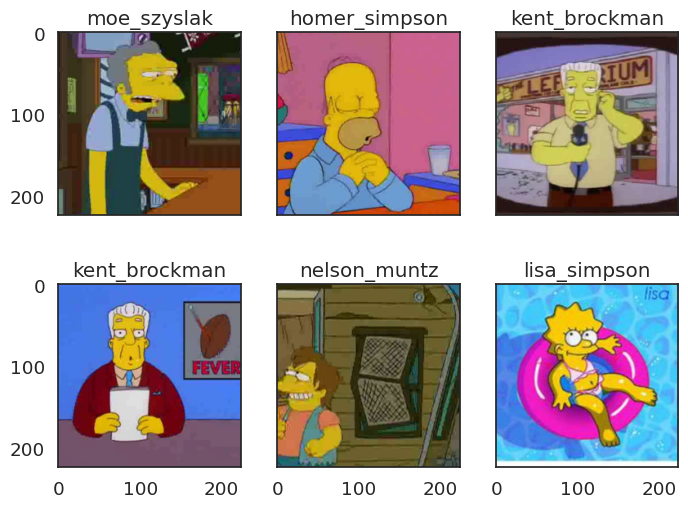

In [7]:
show_images(val_dataset)

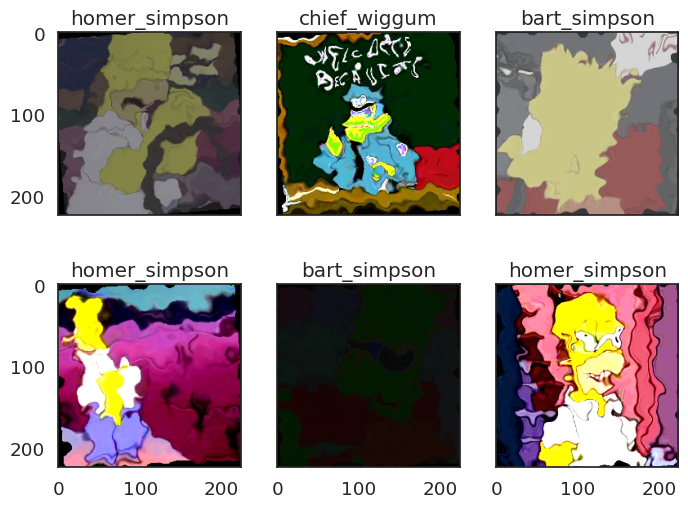

In [8]:
show_images(train_dataset)

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [10]:
def plot_learning_curves(history):
    '''
    Функция для вывода графиков лосса и метрики во время обучения.
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

In [11]:
def train(
    model, 
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    scheduler1=None,
    scheduler2=None,
    num_epochs=10
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True) 

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch)
            
            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)
            
        if scheduler1!=None:    
            scheduler1.step()
        if scheduler2!=None:
            scheduler2.step()
        
        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen) 
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
    
        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False) 

        # полностью проходим по валидационному датасету  
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen) 
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)
        
        clear_output()

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
        plot_learning_curves(history)
        
    return model, history

In [12]:
batch_size = 256

# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
# валидационный датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

#### Будем использовать сеть как `Feature Extractor`

In [13]:
import torchvision as tv
import torch.optim.lr_scheduler as lr_scheduler

Epoch 10 of 10 took 956.214s
  training loss (in-iteration): 	3.020129
  validation loss (in-iteration): 	2.981816
  training accuracy: 			13.53 %
  validation accuracy: 			17.87 %


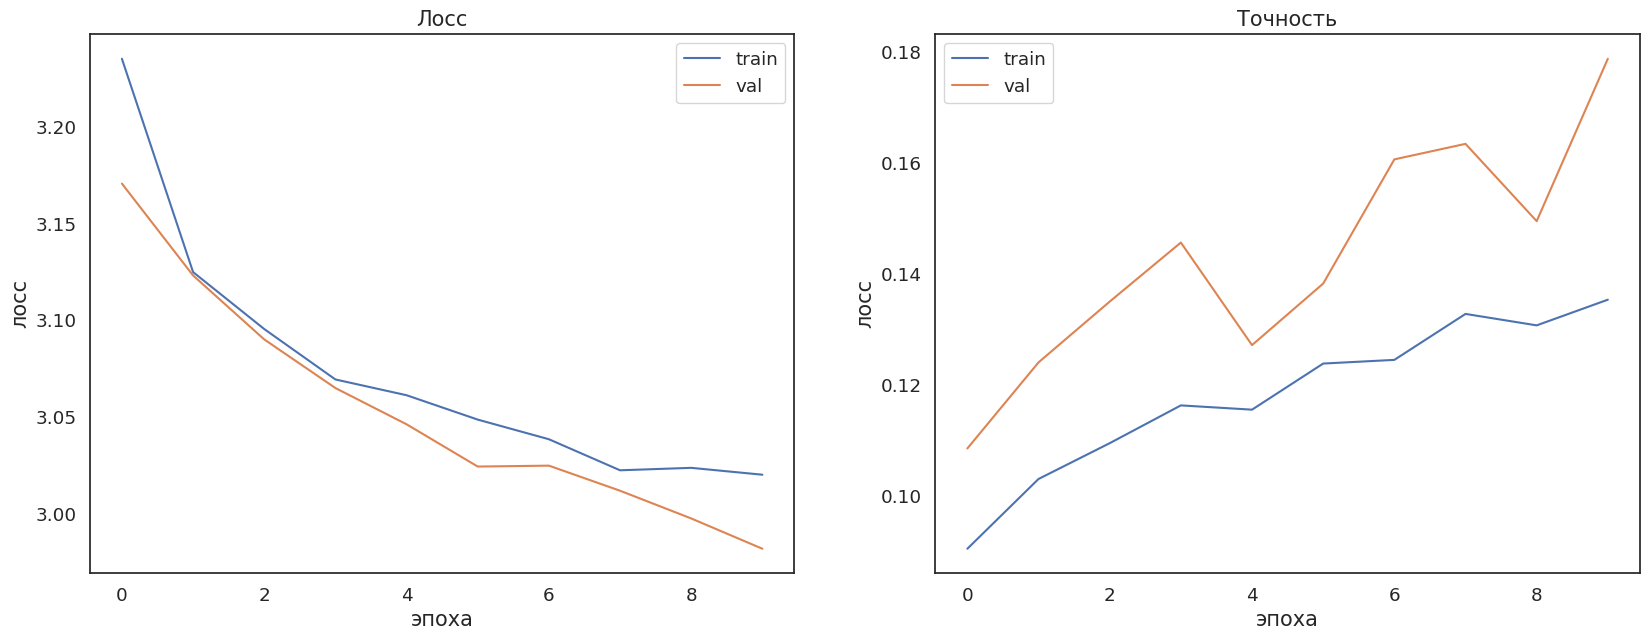

In [14]:
# возьмём предобученную сеть
fe_model = tv.models.vgg16(weights='IMAGENET1K_V1')

# заморозим все слои сети
for param in fe_model.parameters():
    param.requires_grad = False

# добавим над feature extractor сетью классификационный слой
fe_model.classifier[6] = nn.Linear(4096, 42)
fe_model = fe_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fe_model.parameters(), lr=0.01)


#scheduler1 = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
#scheduler2 = lr_scheduler.MultiStepLR(optimizer, milestones=[3,8], gamma=0.1)

clf_model, history = train(
    fe_model, criterion, optimizer,  
    train_batch_gen, val_batch_gen, 
    num_epochs=10
)

In [ ]:
'''input_size = 224

### Добавим аугметации 
### transforms.RandomRotation(degrees=(0, 180)), 
### transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
### чтобы ухудшить итоговое качество на валидации.

train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.RandomRotation(degrees=(0, 180)),
    transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
    transforms.ColorJitter(0.9, 0.9, 0.9),
    transforms.RandomAffine(5),
    transforms.ToTensor(),
])


val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=train_transform,
    is_valid_file=lambda x: x in train_files_path
)

val_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=val_transform,
    is_valid_file=lambda x: x in val_files_path
)'''

In [ ]:
'''batch_size = 256

# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
# валидационный датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)'''

In [ ]:
#show_images(train_dataset)

In [ ]:
'''# возьмём предобученную сеть
fe_model = tv.models.vgg16(weights='IMAGENET1K_V1')

# заморозим все слои сети
for param in fe_model.parameters():
    param.requires_grad = False

# добавим над feature extractor сетью классификационный слой
fe_model.classifier[6] = nn.Linear(4096, 42)
fe_model = fe_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fe_model.parameters(), lr=0.01)


#scheduler1 = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
#scheduler2 = lr_scheduler.MultiStepLR(optimizer, milestones=[3,8], gamma=0.1)

clf_model, history = train(
    fe_model, criterion, optimizer,  
    train_batch_gen, val_batch_gen, 
    num_epochs=10
)'''

#### Выше получено ухудшение Accuracy при неправильной аугментации.

#### 1.Модифицируйте код обучения, используя различные типы LR Schedulers из Pytorch. Проведите минимум 2 эксперимента с разными шедулерами.

#### 3.Возьмите любую архитектуру (VGG, EfficientNet или MobileNet) и примените к ней методы, которые разбирались на занятии.

#### Теперь получим результаты на исходной аугментации для предобученной сети VGG16 с разными LRshedulers и использованием FineTuning и FeaturesExtraction.

In [14]:
# Исходная аугментация с занятия.
input_size = 224

train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ColorJitter(0.9, 0.9, 0.9),
    transforms.RandomAffine(5),
    transforms.ToTensor(),
])


val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=train_transform,
    is_valid_file=lambda x: x in train_files_path
)

val_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=val_transform,
    is_valid_file=lambda x: x in val_files_path
)

In [15]:
batch_size = 64

# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
# валидационный датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

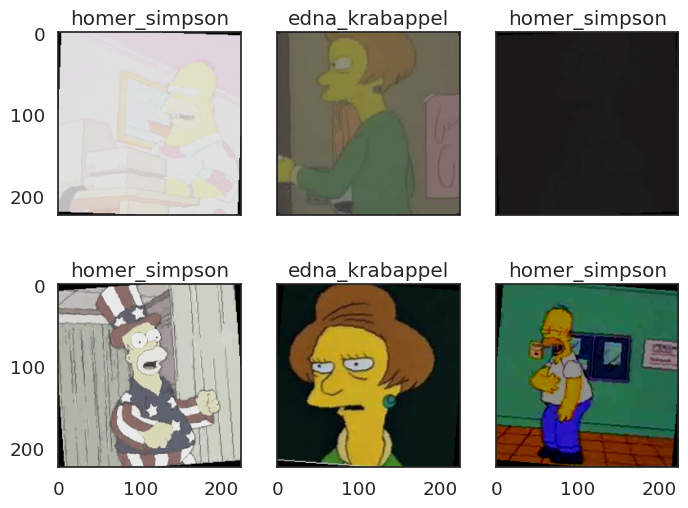

In [16]:
show_images(train_dataset)

#### `Feature Extractor`

Epoch 10 of 10 took 221.388s
  training loss (in-iteration): 	2.325220
  validation loss (in-iteration): 	1.974004
  training accuracy: 			36.05 %
  validation accuracy: 			49.34 %


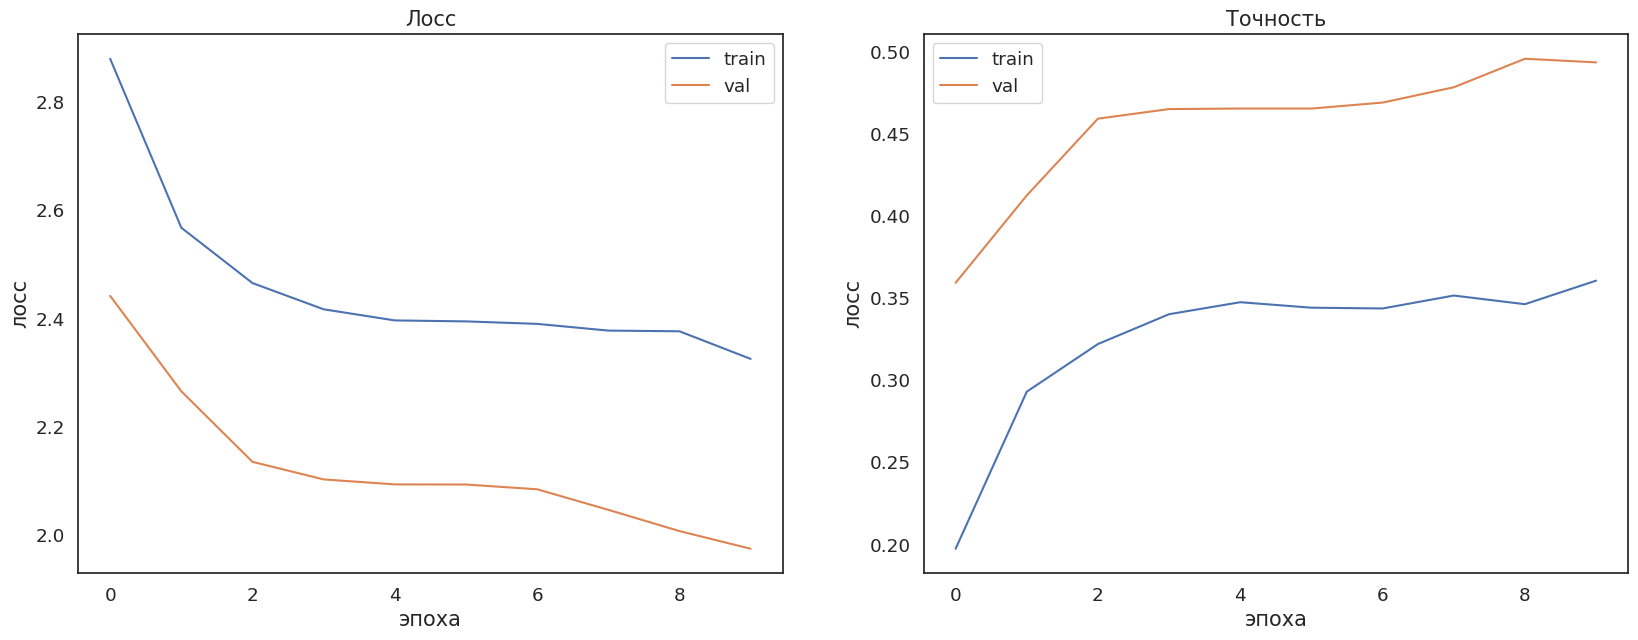

In [40]:
# возьмём предобученную сеть
fe_model = tv.models.vgg16(weights='IMAGENET1K_V1')

# заморозим все слои сети
for param in fe_model.parameters():
    param.requires_grad = False

# добавим над feature extractor сетью классификационный слой
fe_model.classifier[6] = nn.Linear(4096, 42)
fe_model = fe_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fe_model.parameters(), lr=0.01)


scheduler1 = lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=0.00001)
#scheduler2 = lr_scheduler.MultiStepLR(optimizer, milestones=[3,8], gamma=0.1)

clf_model, history = train(
    fe_model, criterion, optimizer,  
    train_batch_gen, val_batch_gen, 
    scheduler1, num_epochs=10
)

#### `FineTuning

In [11]:
from torchvision.models import vgg16

In [17]:
fine_tuning_model = nn.Sequential()

fine_tuning_model.add_module('vgg16',vgg16(weights='IMAGENET1K_V1'))

# добавим новые слои для классификации для нашей конкретной задачи
fine_tuning_model.add_module('relu_1', nn.ReLU(inplace=True))
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU(inplace=True))
fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 277MB/s] 


Epoch 10 of 10 took 267.955s
  training loss (in-iteration): 	0.300447
  validation loss (in-iteration): 	0.289033
  training accuracy: 			91.72 %
  validation accuracy: 			93.10 %


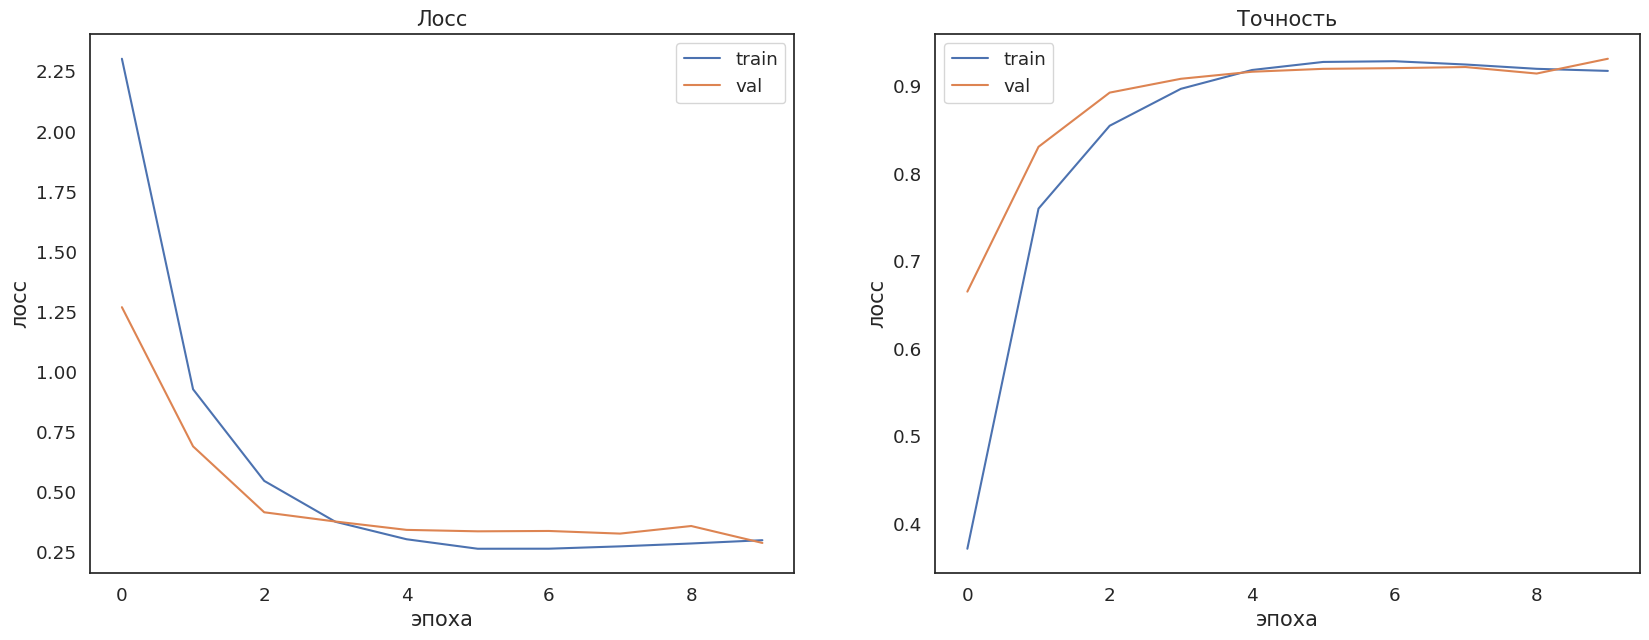

In [18]:


fine_tuning_model = fine_tuning_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)

scheduler1 = lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=0.001)
#scheduler2 = lr_scheduler.MultiStepLR(optimizer, milestones=[3,8], gamma=0.95)

clf_model, history = train(
    fine_tuning_model, criterion, optimizer,  
    train_batch_gen, val_batch_gen, 
    scheduler1, num_epochs=10
)

#### Теперь получим результаты на исходной аугментации, обучив сеть VGG16 на Simpsons_dataset, с  LRsheduler.

Epoch 10 of 10 took 251.390s
  training loss (in-iteration): 	2.508278
  validation loss (in-iteration): 	2.358000
  training accuracy: 			29.86 %
  validation accuracy: 			34.06 %


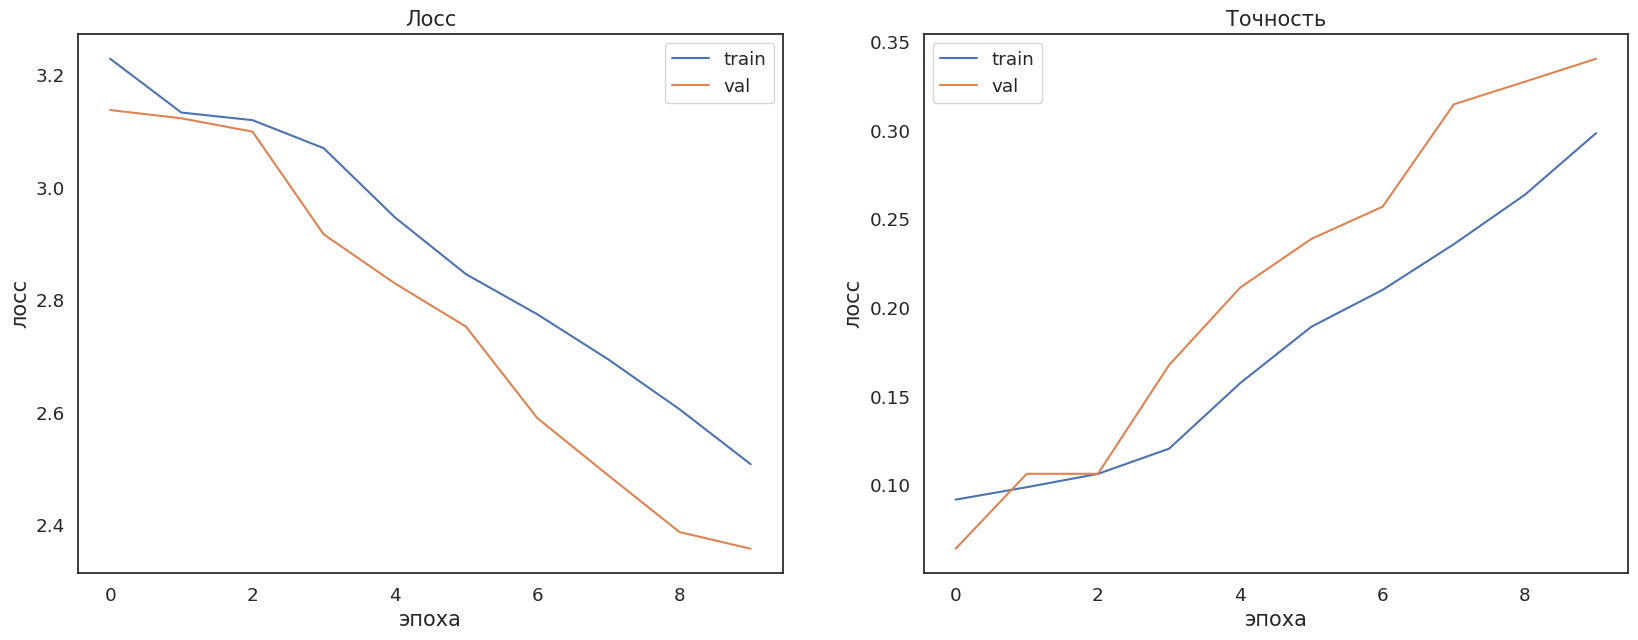

In [19]:
model_lrn = tv.models.vgg16() #resnet18(pretrained=False  #model.fc = nn.Linear(512, 42)
model_lrn.classifier[6] = nn.Linear(4096, 42)
model_lrn = model_lrn.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_lrn.parameters(), lr=0.01)

scheduler2 = lr_scheduler.MultiStepLR(optimizer, milestones=[2,5,9], gamma=0.95)

clf_model, history = train(
    model_lrn, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    scheduler2, num_epochs=10
)

#### 4. Оформите вывод по результатам проведённых экспериментов.

#### Вывод
1. Аугментации
transforms.ElasticTransform(alpha=250.0),
transforms.RandomSolarize(threshold=192.0),
ухудшили итоговое качество на валидации.
1. Метод FineTuning превошел по качеству метод FeatureExtraction.
1. Resnet18, рассмотренная на занятии, превзошла VGG16.
